# Question 5 – Pima Diabetes: Prediction Type and PCA
Dataset: `pima-diabetes.xlsx`.

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

def load_pima():
    for p in ['pima-diabetes.xlsx', 'pima_diabetes.xlsx', '/mnt/data/pima-diabetes.xlsx', '/mnt/data/pima_diabetes.xlsx']:
        if os.path.exists(p):
            path = p
            break
    else:
        raise FileNotFoundError('pima-diabetes.xlsx not found')

    df = pd.read_excel(path)

    # Normalize Outcome column name and type
    outcome_cols = [c for c in df.columns if c.strip().lower() == 'outcome']
    if outcome_cols:
        oc = outcome_cols[0]
        if oc != 'Outcome':
            df = df.rename(columns={oc: 'Outcome'})
    df['Outcome'] = pd.to_numeric(df['Outcome'], errors='coerce')

    return df

pima = load_pima()
pima.head()


,Outcome,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,NaN,6,148.0,72.0,35.0,NaN,33.6,0.627,50
1,NaN,1,85.0,66.0,29.0,NaN,26.6,0.351,31
2,NaN,8,183.0,64.0,NaN,NaN,23.3,0.672,32
3,NaN,1,89.0,66.0,23.0,94.0,28.1,0.167,21
4,NaN,0,137.0,40.0,35.0,168.0,43.1,2.288,33


## 5(a) Question – Regression or Classification?
> What kind of prediction is made for this purpose? Is it regression or classification? Give reasons.
> What will be the effect if the Outcome is changed into 0 (non-diabetic) and 1 (diabetic)?

In [2]:
# 5(a) – Inspect Outcome values

pima['Outcome'].value_counts()

Series([], Name: count, dtype: int64)

### 5(a) Explanation – Prediction Type

Outcome indicates whether a patient is **diabetic** or **non-diabetic**, so the target is **categorical** with two
classes. This makes the task a **binary classification** problem.

- **Classification** predicts class labels (0/1), possibly with associated probabilities.
- **Regression** predicts continuous numeric values (e.g., blood sugar level).

Encoding Outcome as 0 for non-diabetic and 1 for diabetic is just a **numerical encoding of the classes**. The
problem remains classification; the encoding makes it convenient to use algorithms such as logistic regression,
decision trees, and random forests, which expect numerical labels.

## 5(b) Question – Why PCA and How Many Components?
> Before prediction, the number of features will be reduced using PCA. Why is feature reduction
> desired? Perform PCA on the data, explain the results, and decide how many features should be
> used at the end.

PC1: explained var ratio=0.285, cumulative=0.285
PC2: explained var ratio=0.187, cumulative=0.472
PC3: explained var ratio=0.143, cumulative=0.615
PC4: explained var ratio=0.115, cumulative=0.730
PC5: explained var ratio=0.096, cumulative=0.826
PC6: explained var ratio=0.068, cumulative=0.894
PC7: explained var ratio=0.059, cumulative=0.952
PC8: explained var ratio=0.048, cumulative=1.000


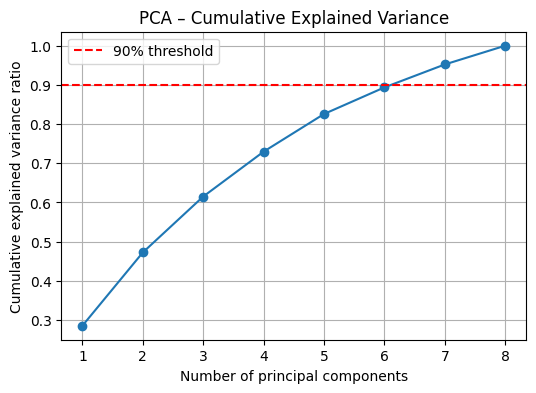

In [3]:
# 5(b) – PCA on standardized features with median imputation (no listwise deletion)

features = pima.drop(columns=['Outcome'])
target = pima['Outcome']

# Impute missing values column-wise (median) – respects "no list deletion"
features_imputed = features.copy()
for col in features_imputed.columns:
    median_val = features_imputed[col].median(skipna=True)
    features_imputed[col] = features_imputed[col].fillna(median_val)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(features_imputed)

pca = PCA()
X_pca = pca.fit_transform(X_scaled)

explained_var = pca.explained_variance_ratio_
cum_explained = explained_var.cumsum()

for i, (ev, cv) in enumerate(zip(explained_var, cum_explained), start=1):
    print(f'PC{i}: explained var ratio={ev:.3f}, cumulative={cv:.3f}')

plt.figure(figsize=(6,4))
plt.plot(range(1, len(explained_var)+1), cum_explained, marker='o')
plt.axhline(0.9, color='r', linestyle='--', label='90% threshold')
plt.xlabel('Number of principal components')
plt.ylabel('Cumulative explained variance ratio')
plt.title('PCA – Cumulative Explained Variance')
plt.grid(True)
plt.legend()
plt.show()


### 5(b) Explanation – PCA Motivation and Component Choice

**Why reduce features?** (from PCA & curse of dimensionality slides)
- Too many features → data becomes **sparse**, distances lose meaning, and models may **overfit**.
- Some features are highly correlated (multicollinearity), providing redundant information.

PCA constructs new variables (principal components) as linear combinations of original features such that:
- PC1 captures the largest possible variance,
- PC2 captures the next largest variance, orthogonal to PC1, and so on.

If $\lambda_i$ are eigenvalues of the covariance matrix, the explained variance ratio of PC i is:
$$ \text{EVR}_i = \frac{\lambda_i}{\sum_j \lambda_j}. $$
The cumulative sum tells us how many components are needed to explain, say, **90%** of the total variance.

From the printed values and plot, we choose the smallest number $k$ such that cumulative EVR exceeds 0.9.
These first $k$ PCs will then be used as input features for classification, reducing dimensionality while keeping
most of the information.